# Prof. Pedram Jahangiry

You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_Learning-USU/blob/main/Lectures%20and%20codes/Module%206-%20Deep%20Sequence%20Modeling/python/Module%206-%20NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center)


## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


# Module 6- Deep Sequence Modeling (Part 2: NLP)

This module provides a comprehensive overview of fundamental concepts and techniques related to deep sequence modeling. Part one explores deep learning for timeseries data, highlighting the inadequacy of DNN and CNN architectures for this task and introducing the recurrent neural network (RNN) as a solution. Part two delves into deep learning for natural language processing (NLP), illustrating how neural networks can be employed to process human language. The module concludes with a practical exercise in which students apply the concepts they have learned to build a deep sequence model and perform NLP tasks using TensorFlow in Python.

This notebook has been adapted from Deep learning with Python (2nd edition). Francois Chollet
https://github.com/fchollet/deep-learning-with-python-notebooks

# Installation

* If you want to run your code on Google Colab, there is no installation required. (recommended for the course)
* If you want to run your code locally, then you need to install tensorflow https://www.tensorflow.org/install



In [1]:
import tensorflow
tensorflow.__version__

'2.14.0'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preparing text data

We start by TextVectorization: : the process of transforming text into numeric values.


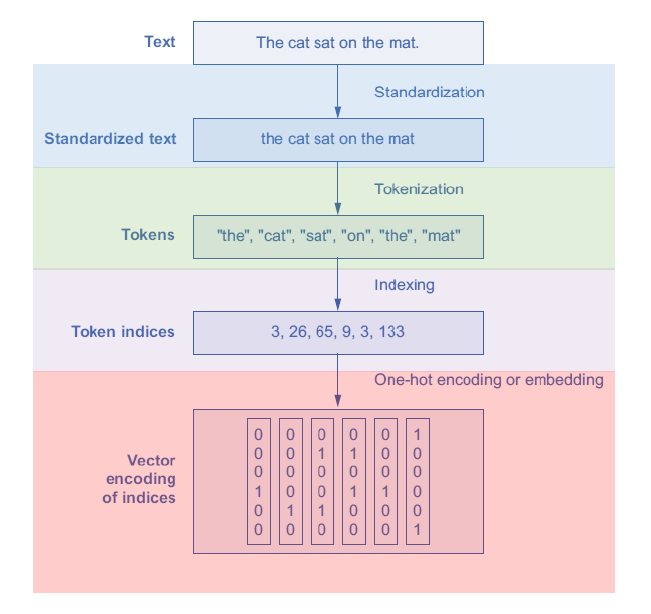

In [3]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(output_mode='int',) # return sequence of words encoded as integers.


Remember:
* To index the vocabulary of a text corpus, we can call the **adapt()** method.
* To **retrieve** the computed vocabulary we can use **get_vocabulary()** method.
* index 0 and 1 are reserved for padding and OOV (out of vocabulary), respectively.
* TextVectorization layer uses "convert to lowercase" and "remove punctuation" for **standardization**, and "split on whitespace" for **tokenization**.


In [4]:
text_data = ["The Cat Sat on THE mAT!!!"] # this is the entire data set you want to adapt.
text_vectorization.adapt(text_data)

In [5]:
text_vectorization.get_vocabulary()

['', '[UNK]', 'the', 'sat', 'on', 'mat', 'cat']

In [6]:
text_vectorization(text_data)

<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[2, 6, 3, 4, 2, 5]])>

Now let's encode a new test data based on our existing vectorizer.

In [7]:
# Define some input text

input_text = "Cat on the table?"

In [8]:
# Call the TextVectorization layer on the input text

encoded_input = text_vectorization(input_text)
print(encoded_input)

tf.Tensor([6 4 2 1], shape=(4,), dtype=int64)


Now let's translate this list of integers back into their corresponding words.

In [9]:
# Get the vocabulary and index-to-word mapping

vocabulary= text_vectorization.get_vocabulary()

In [10]:
index_to_word = dict(enumerate(vocabulary))
index_to_word

{0: '', 1: '[UNK]', 2: 'the', 3: 'sat', 4: 'on', 5: 'mat', 6: 'cat'}

In [11]:
decoded_input = " ".join(index_to_word[int(i)] for i in encoded_input)
print(decoded_input)

cat on the [UNK]


# Importing the IMBD data

Download the dataset from Stanford page of Andrew Maas! this is a balanced dataset with 12.5k positive and 12.5k negative reviews for the train and test set (25k each).

In [12]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  4626k      0  0:00:17  0:00:17 --:--:-- 4742k


We don't need the unsup subdirectory.

In [13]:
!rm -r aclImdb/train/unsup

We can checkout one of the reviews from the train set!

In [14]:
!cat aclImdb/train/pos/10001_10.txt

Brilliant over-acting by Lesley Ann Warren. Best dramatic hobo lady I have ever seen, and love scenes in clothes warehouse are second to none. The corn on face is a classic, as good as anything in Blazing Saddles. The take on lawyers is also superb. After being accused of being a turncoat, selling out his boss, and being dishonest the lawyer of Pepto Bolt shrugs indifferently "I'm a lawyer" he says. Three funny words. Jeffrey Tambor, a favorite from the later Larry Sanders show, is fantastic here too as a mad millionaire who wants to crush the ghetto. His character is more malevolent than usual. The hospital scene, and the scene where the homeless invade a demolition site, are all-time classics. Look for the legs scene and the two big diggers fighting (one bleeds). This movie gets better each time I see it (which is quite often).

## preparing train, val and test data folders

In [15]:
# moving 20% of the train data into a new folder called val.
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb") # define the directories that will be used to store the data.
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category) # Creates a subdirectory in val_dir with the name of the category (e.g. "val/neg").
    files = os.listdir(train_dir / category) # Lists all the files in the corresponding category directory in train_dir.
    random.Random(1337).shuffle(files) # Shuffles the list of files in a reproducible way using a fixed seed (1337).
    num_val_samples = int(0.2 * len(files)) # Calculates the number of validation samples as 20% of the total number of files in the category.
    val_files = files[-num_val_samples:] # Selects the last num_val_samples files in the shuffled list as the validation files.
    for fname in val_files: # Moves each validation file from train_dir to val_dir for the current category using shutil.move()
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

We use **text_dataset_from_directory** utility to create batched Dataset of text and lables. This is analogous to what we used in CNN, image_dataset_from_directory.

In [16]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [17]:
# Displaying the shapes and dtypes of the first batch**

for inputs, targets in train_ds.take(1):
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])


inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'A text prologue warns us that we should not allow evil to enter our house, but I think the more apt word is "entropy." Good grief, what slobs these two babes are!<br /><br />George (Seymour Cassell) is alone in his San Francisco office and his monstrously expensive home in Tiburon while his wife and child are away in San Diego. Two girls (Sondra Locke as Jackson and Colleen Camp as Donna) knock on his door, asking directions. Well, it\'s raining, and they\'re shivering like two drenched pitiful kittens, and they\'re not sure of the address they\'re looking for, and, what with one thing and another, George invites them to come in and partake of his pizza by the fire. All three of them wind up in George\'s bath tub and there follows about five minutes of mostly undifferentiated nudity in double exposure, triple exposure, quadruple exposure, and dodekakuple expos

# Representing groups of words

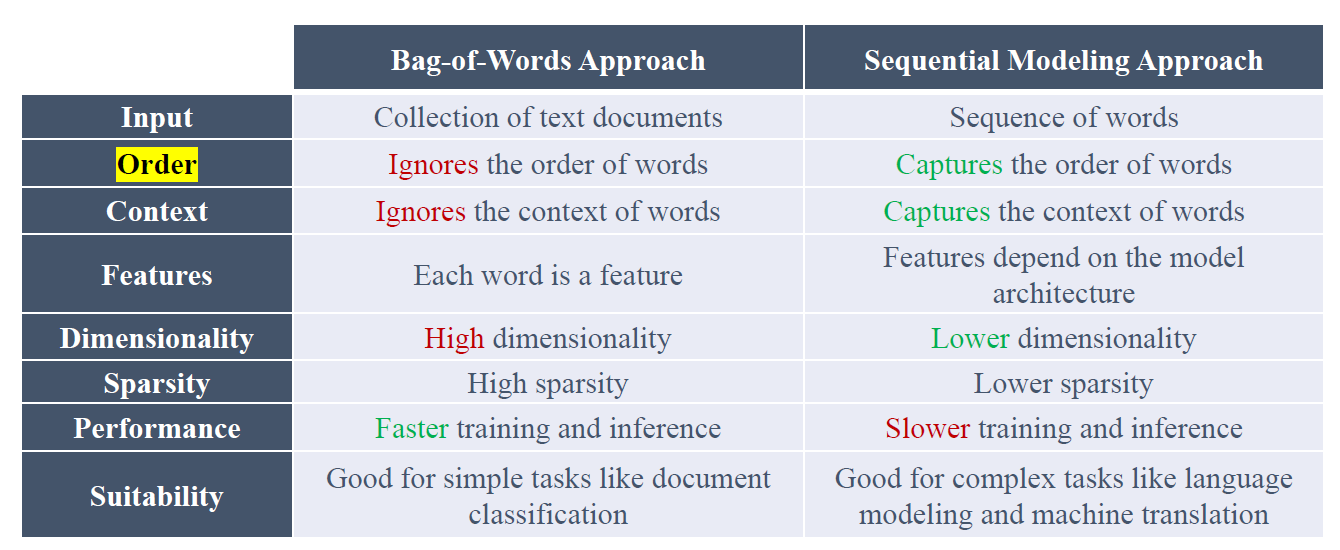


## Bag-of-words



### 1.Single words (Unigrams) with binary encoding (multi-hot)

In [18]:
text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="multi_hot",
) # This layer will be used to vectorize the textual data in the datasets.

# prepare the TextVectorization layer for use by fitting it to the training dataset.
text_only_train_ds = train_ds.map(lambda x,y : x) # discarding the labels y.
text_vectorization.adapt(text_only_train_ds) #  adapt method analyzes the text data to generate a vocabulary and configure the layer's settings for text processing.

# creating new datasets with the vectorized data
binary_1gram_train_ds = train_ds.map(
    lambda x,y : (text_vectorization(x), y),
    num_parallel_calls=4) #  The num_parallel_calls argument specifies the number of parallel calls to use for the mapping operation, which can speed up processing for large datasets.
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [19]:
for inputs, targets in binary_1gram_train_ds.take(1):
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])


inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 0. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


In [20]:
# Building the model

from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

In [21]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Training the model

callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]
model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)


Epoch 1/10
625/625 [==============================] - 13s 11ms/step - loss: 0.4182 - accuracy: 0.8206 - val_loss: 0.2869 - val_accuracy: 0.8848
Epoch 2/10
 42/625 [=>............................] - ETA: 2s - loss: 0.2997 - accuracy: 0.8876

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 3s 5ms/step - loss: 0.2768 - accuracy: 0.8963 - val_loss: 0.2802 - val_accuracy: 0.8928
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2476 - accuracy: 0.9127 - val_loss: 0.2844 - val_accuracy: 0.8934
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2285 - accuracy: 0.9240 - val_loss: 0.3065 - val_accuracy: 0.8906
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2195 - accuracy: 0.9279 - val_loss: 0.3107 - val_accuracy: 0.8960
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2098 - accuracy: 0.9319 - val_loss: 0.3277 - val_accuracy: 0.8910
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2078 - accuracy: 0.9355 - val_loss: 0.3415 - val_accuracy: 0.8880
Epoch 8/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2025 - accuracy: 0.9350 - val_loss: 0.3528 - val_accuracy: 0.8804
Epoch 9/10
625/62

In [ ]:
# Testing the model

model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

782/782 [==============================] - 6s 7ms/step - loss: 0.2874 - accuracy: 0.8870
Test acc: 0.887


### 2.Two words (Bigrams) with binary encoding (multi-hot)

In [24]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot",
)

In [25]:
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]
model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 10s 15ms/step - loss: 0.3777 - accuracy: 0.8396 - val_loss: 0.2751 - val_accuracy: 0.8892
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2385 - accuracy: 0.9169 - val_loss: 0.2623 - val_accuracy: 0.9018
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2007 - accuracy: 0.9347 - val_loss: 0.2821 - val_accuracy: 0.9016
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1825 - accuracy: 0.9424 - val_loss: 0.3051 - val_accuracy: 0.8990
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1695 - accuracy: 0.9482 - val_loss: 0.3182 - val_accuracy: 0.9024
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1761 - accuracy: 0.9507 - val_loss: 0.3428 - val_accuracy: 0.8986
Epoch 7/10
625/625 [==============================] - 4s 6ms/step - loss: 0.1582 - accuracy: 0.9539 - val_loss: 0.3562 - val_accuracy: 0.8992
Epoc

In [ ]:
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

782/782 [==============================] - 5s 6ms/step - loss: 0.2691 - accuracy: 0.9014
Test acc: 0.901


### 3.Two words (Bigrams) with TF-IDF encoding

In [28]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf",
)

In [29]:
text_vectorization.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)


In [ ]:
model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                    save_best_only=True)
]
model.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)


Epoch 1/10
625/625 [==============================] - 9s 13ms/step - loss: 0.4838 - accuracy: 0.7808 - val_loss: 0.2943 - val_accuracy: 0.8888
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3273 - accuracy: 0.8616 - val_loss: 0.3135 - val_accuracy: 0.8838
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2938 - accuracy: 0.8780 - val_loss: 0.3280 - val_accuracy: 0.8760
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2726 - accuracy: 0.8880 - val_loss: 0.3182 - val_accuracy: 0.8816
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2645 - accuracy: 0.8883 - val_loss: 0.3425 - val_accuracy: 0.8768
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2533 - accuracy: 0.8934 - val_loss: 0.3541 - val_accuracy: 0.8750
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2415 - accuracy: 0.8971 - val_loss: 0.3762 - val_accuracy: 0.8762
Epoch

In [ ]:
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

782/782 [==============================] - 7s 9ms/step - loss: 0.2962 - accuracy: 0.8866
Test acc: 0.887


## Sequence model approach


In [32]:
# preparing integer sequence datasets

from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

### 1.One-hot encoding approach

In [ ]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirection  (None, 64)                5128448   
 al)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5128513 (19.56 MB)
Trainable params: 5128513 (19.56 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [34]:
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 162s 250ms/step - loss: 0.5665 - accuracy: 0.6991 - val_loss: 0.4234 - val_accuracy: 0.8418
Epoch 2/10
625/625 [==============================] - 162s 259ms/step - loss: 0.3674 - accuracy: 0.8624 - val_loss: 0.3830 - val_accuracy: 0.8702
Epoch 3/10
625/625 [==============================] - 163s 261ms/step - loss: 0.2956 - accuracy: 0.8924 - val_loss: 0.3049 - val_accuracy: 0.8790
Epoch 4/10
625/625 [==============================] - 165s 264ms/step - loss: 0.2546 - accuracy: 0.9144 - val_loss: 0.3435 - val_accuracy: 0.8560
Epoch 5/10
625/625 [==============================] - 164s 262ms/step - loss: 0.2203 - accuracy: 0.9269 - val_loss: 0.2862 - val_accuracy: 0.8838
Epoch 6/10
625/625 [==============================] - 164s 262ms/step - loss: 0.1952 - accuracy: 0.9342 - val_loss: 0.2771 - val_accuracy: 0.8896
Epoch 7/10
625/625 [==============================] - 164s 262ms/step - loss: 0.1757 - accuracy: 0.9423 - val_loss: 0.2937 -

In [ ]:
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 98s 124ms/step - loss: 0.3074 - accuracy: 0.8751
Test acc: 0.875


### 2.Word embedding approach

#### 2.1.Word embedding wihtout masking

In [36]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_lstm.keras",
                                    save_best_only=True)
]

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5194049 (19.81 MB)
Trainable params: 5194049 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [38]:
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)


Epoch 1/10
625/625 [==============================] - 61s 92ms/step - loss: 0.5221 - accuracy: 0.7426 - val_loss: 0.3731 - val_accuracy: 0.8456
Epoch 2/10
625/625 [==============================] - 42s 67ms/step - loss: 0.3613 - accuracy: 0.8629 - val_loss: 0.3042 - val_accuracy: 0.8862
Epoch 3/10
625/625 [==============================] - 34s 55ms/step - loss: 0.2851 - accuracy: 0.8949 - val_loss: 0.3293 - val_accuracy: 0.8622
Epoch 4/10
625/625 [==============================] - 32s 52ms/step - loss: 0.2371 - accuracy: 0.9165 - val_loss: 0.3873 - val_accuracy: 0.8456
Epoch 5/10
625/625 [==============================] - 31s 49ms/step - loss: 0.2101 - accuracy: 0.9287 - val_loss: 0.5268 - val_accuracy: 0.8298
Epoch 6/10
625/625 [==============================] - 30s 49ms/step - loss: 0.1857 - accuracy: 0.9386 - val_loss: 0.3660 - val_accuracy: 0.8708
Epoch 7/10
625/625 [==============================] - 30s 48ms/step - loss: 0.1533 - accuracy: 0.9505 - val_loss: 0.3623 - val_accuracy:

In [ ]:
model = keras.models.load_model("embeddings_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 18s 21ms/step - loss: 0.3367 - accuracy: 0.8685
Test acc: 0.869


#### 2.2.Word embedding with masking

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_lstm_with_masking.keras",
                                    save_best_only=True)
]


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5194049 (19.81 MB)
Trainable params: 5194049 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [42]:
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)


Epoch 1/10
625/625 [==============================] - 72s 100ms/step - loss: 0.4518 - accuracy: 0.7853 - val_loss: 0.3209 - val_accuracy: 0.8764
Epoch 2/10
625/625 [==============================] - 44s 71ms/step - loss: 0.2810 - accuracy: 0.8906 - val_loss: 0.2891 - val_accuracy: 0.8806
Epoch 3/10
625/625 [==============================] - 38s 61ms/step - loss: 0.2200 - accuracy: 0.9157 - val_loss: 0.4098 - val_accuracy: 0.8452
Epoch 4/10
625/625 [==============================] - 35s 56ms/step - loss: 0.1693 - accuracy: 0.9390 - val_loss: 0.3097 - val_accuracy: 0.8856
Epoch 5/10
625/625 [==============================] - 33s 53ms/step - loss: 0.1347 - accuracy: 0.9530 - val_loss: 0.3315 - val_accuracy: 0.8788
Epoch 6/10
625/625 [==============================] - 36s 57ms/step - loss: 0.1037 - accuracy: 0.9650 - val_loss: 0.3274 - val_accuracy: 0.8760
Epoch 7/10
625/625 [==============================] - 33s 53ms/step - loss: 0.0815 - accuracy: 0.9731 - val_loss: 0.3839 - val_accuracy

In [ ]:
model = keras.models.load_model("embeddings_bidir_lstm_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 19s 21ms/step - loss: 0.3060 - accuracy: 0.8770
Test acc: 0.877


#### 2.3.Pre-trained word embedding

Let's use GloVe scheme for word embedding: https://nlp.stanford.edu/projects/glove/

In [44]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-11-15 04:31:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-11-15 04:31:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-11-15 04:31:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [45]:
# Parsing the GloVe word-embeddings file
import numpy as np

# GloVe word-embeddings file, which contains pre-trained word vectors that can be used to initialize a neural network's embedding layer
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1) #  The maxsplit=1 argument ensures that the split is only performed once, so that the coefficients string can contain spaces.
        coefs = np.fromstring(coefs, "f", sep=" ") # This line converts the string of coefficients to a NumPy array of float32 values. values should be separated by spaces.
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")
# the GloVe file contains pre-trained word vectors for 400,000 unique words.


Found 400000 word vectors.


By loading pre-trained word vectors, you can avoid the need to train your own word embeddings from scratch, which can be a time-consuming process that requires large amounts of text data. Pre-trained word vectors can also be useful in cases where you have limited training data and need to rely on pre-existing knowledge about the relationships between words to achieve good performance on your task.

The following block of code populates the **embedding_matrix** with the pre-trained GloVe word embeddings.

For each token in the vocabulary, the corresponding embedding vector is retrieved from the embeddings_index dictionary that was created earlier. If the vector is not None, it is assigned to the corresponding row of the embedding_matrix. If the vocabulary size is larger than max_tokens, only the first max_tokens tokens are used and the rest are ignored.

Overall, this code prepares a matrix of pre-trained word embeddings that can be used to initialize the embedding layer in a neural network for a natural language processing task. The embedding layer can then be trained along with the rest of the model using the training data, or it can be kept fixed and used to extract features from new text data.

In [46]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary)))) # maps each token in the vocabulary to an integer index.

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [47]:
embedding_layer = layers.Embedding(
    max_tokens, # The maximum vocabulary size, which was previously defined as 20,000
    embedding_dim, # The dimensionality of the word embeddings, which was previously defined as 100.
    embeddings_initializer=keras.initializers.Constant(embedding_matrix), # used to initialize the weights with the pre-trained GloVe word embeddings that were loaded earlier.
    trainable=False, # specifies whether the weights of the embedding layer should be trainable during training of the model
    mask_zero=True, # specifies whether the embedding layer should treat zeros as a special "padding" value that should be masked out during training.
)

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                34048     
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2034113 (7.76 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 2000000 (7.63 MB)
_________________

In [49]:
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)


Epoch 1/10
625/625 [==============================] - 72s 102ms/step - loss: 0.5739 - accuracy: 0.6981 - val_loss: 0.4588 - val_accuracy: 0.7928
Epoch 2/10
625/625 [==============================] - 63s 100ms/step - loss: 0.4462 - accuracy: 0.7990 - val_loss: 0.3802 - val_accuracy: 0.8292
Epoch 3/10
625/625 [==============================] - 53s 84ms/step - loss: 0.3948 - accuracy: 0.8300 - val_loss: 0.4614 - val_accuracy: 0.7960
Epoch 4/10
625/625 [==============================] - 49s 77ms/step - loss: 0.3612 - accuracy: 0.8462 - val_loss: 0.3243 - val_accuracy: 0.8596
Epoch 5/10
625/625 [==============================] - 32s 51ms/step - loss: 0.3364 - accuracy: 0.8601 - val_loss: 0.3313 - val_accuracy: 0.8572
Epoch 6/10
625/625 [==============================] - 38s 60ms/step - loss: 0.3158 - accuracy: 0.8679 - val_loss: 0.3195 - val_accuracy: 0.8682
Epoch 7/10
625/625 [==============================] - 53s 84ms/step - loss: 0.2987 - accuracy: 0.8756 - val_loss: 0.3002 - val_accurac

In [ ]:
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

# Making predictions on new data!

In [ ]:
# laoding your prefered model first.
model = keras.models.load_model("binary_2gram.keras")

text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot",
)


# Adapt the TextVectorization layer to the training data
text_vectorization.adapt(text_only_train_ds)


In [52]:
input_text = ["That was an excellent movie, I loved it.", "This was the worst movie ever. I hated it!!"] # list of your new reviews
vectorized_text = text_vectorization(input_text)
output = model.predict(vectorized_text)
print(output)

1/1 [==============================] - 1s 780ms/step
[[0.92581534]
 [0.07902755]]


Done!